In [1]:
%matplotlib inline

/Users/yaolun/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def CircularAperture(x, y, r, pix=10000.):
    import numpy as np
    
    grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
    grid_x = grid_x - (pix-1)/2.
    grid_y = grid_y - (pix-1)/2.
    grid_dist = ((grid_x-x)**2+(grid_y-y)**2)**0.5
    aperture = np.where(grid_dist <= r, np.full((pix, pix), 1, dtype=int), 0)
    
    return aperture

In [3]:
def Total_MaskedAperture(aperture, mask):
    import numpy as np
    
    aperture_masked = np.where(mask != 0, aperture, 0)
    
    return aperture_masked, np.sum(aperture_masked)

In [4]:
def Mask(x, y, edge, rot, pix=10000.):
    import numpy as np
    from scipy.ndimage.interpolation import rotate
    
    init_arr = np.full((pix, pix), 1, dtype=int)
    grid_x, grid_y = np.meshgrid(np.linspace(0,pix-1,pix), np.linspace(0,pix-1,pix))
    
    # RA offset (x) and Dec offset (y) need to be rotated, because the spaxels are rotated.
    rotMatrix = np.array([[np.cos(np.radians(rot)), -np.sin(np.radians(rot))], 
                          [np.sin(np.radians(rot)),  np.cos(np.radians(rot))]])
    coord_rot = np.squeeze(np.dot(rotMatrix, np.array([x,y]).reshape(2,1)))
    
    dist_x = abs(grid_x - (pix-1)/2. - coord_rot[0])
    dist_y = abs(grid_y - (pix-1)/2. - coord_rot[1])
    
#     dist_x = abs(grid_x - (pix-1)/2. - x)
#     dist_y = abs(grid_y - (pix-1)/2. - y)
    
    aper_trim = np.where((dist_x <= edge/2.) & (dist_y <= edge/2.), init_arr, 0)
    
    return aper_trim

In [5]:
from astropy.io import ascii
import numpy as np
mean_coord = {'RA':[], 'Dec':[]}
coord = {'RA':[], 'Dec':[]}
foo_cen = ascii.read('/Users/yaolun/bhr71/calibration_testing/HSA/cube/BHR71_pacs_pixel13_hsa_coord.txt')
cen_ra, cen_dec = foo_cen['RA(deg)'][0], foo_cen['Dec(deg)'][0]
mean_cen_ra, mean_cen_dec = np.mean(foo_cen['RA(deg)']), np.mean(foo_cen['Dec(deg)'])

for i in range(1,26):
    foo = ascii.read('/Users/yaolun/bhr71/calibration_testing/HSA/cube/BHR71_pacs_pixel'+str(i)+'_hsa_coord.txt')
    mean_coord['RA'].append((np.mean(foo['RA(deg)']) - mean_cen_ra)*np.cos(np.radians(mean_cen_dec))*3600.)
    mean_coord['Dec'].append((np.mean(foo['Dec(deg)']) - mean_cen_dec)*3600.)

    coord['RA'].append((foo['RA(deg)'][0]-cen_ra)*np.cos(np.radians(cen_dec))*3600.)
    coord['Dec'].append((foo['Dec(deg)'][0]-cen_dec)*3600.)

In [11]:
# do 60" x 60"
pix = 1000.
factor = pix/60.
weight = []
aperture = CircularAperture(0, 0, 15.9*factor, pix=pix)
ideal = (9.4*factor)**2

rot_angle = -337.59912046069104

a = np.full((pix, pix), 0)
for i in range(0,25):
    ra = coord['RA'][i]
    dec = coord['Dec'][i]
    masked_arr, arr_sum = Total_MaskedAperture(aperture, Mask(ra*factor, dec*factor, 8.417*factor, rot_angle, pix=pix))
    a = a + masked_arr
    weight.append(arr_sum)

# somehow there is about 1% error even if the whole spaxel should be within the circular aperture
for i in range(len(weight)):
    if np.abs(weight[i]/ideal) >= 0.99:
        weight[i] = 1
    else:
        weight[i] = weight[i]/ideal

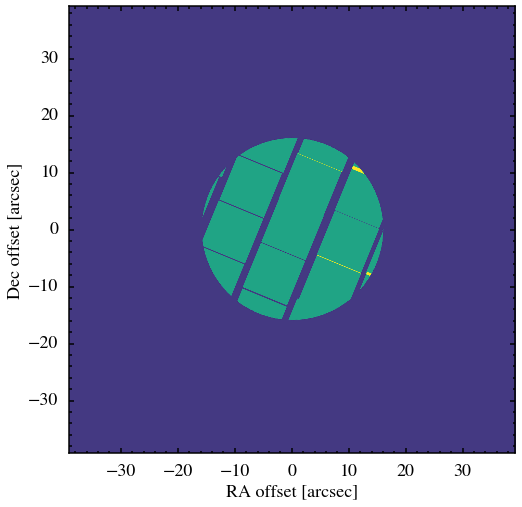

In [12]:
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
factor_rot = len(rotate(a, -rot_angle)[:,0])/pix

ax.imshow(rotate(a, -rot_angle), extent=[-30*factor_rot,30*factor_rot,-30*factor_rot,30*factor_rot],
          cmap='viridis', vmax=2)

[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)
ax.set_xlabel('RA offset [arcsec]', fontsize=18)
ax.set_ylabel('Dec offset [arcsec]', fontsize=18)

fig.savefig('/Users/yaolun/bhr71/calibration_testing/pacs_masked.pdf', format='pdf', dpo=300, bbox_inches='tight')

In [235]:
foo_cen = ascii.read('/Users/yaolun/bhr71/calibration_testing/HSA/cube/BHR71_pacs_pixel13_hsa.txt')
wl = foo_cen['Wavelength(um)']
flux = np.zeros_like(foo_cen['Flux_Density(Jy)'])

for i in range(1,26):
    foo = ascii.read('/Users/yaolun/bhr71/calibration_testing/HSA/cube/BHR71_pacs_pixel'+str(i)+'_hsa.txt')
    flux = flux + foo['Flux_Density(Jy)']*weight[i-1]

# write the weighted spectrum into a file
foo = open('/Users/yaolun/bhr71/calibration_testing/HSA/pacs_weighted_318aper.txt','w')
foo.write('{} \t {}\n'.format('Wavelength(um)', 'Flux(Jy)'))
for i in range(len(wl)):
    foo.write('{} \t {}\n'.format(wl[i], flux[i]))
foo.close()

<Container object of 3 artists>

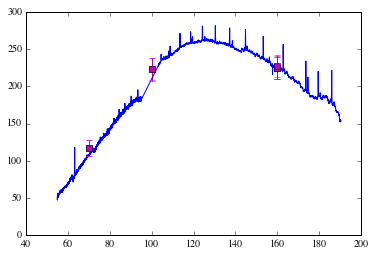

In [236]:
plt.plot(wl, flux)
plt.errorbar([70,70,100,100,160,160,160,160],
            [117.45,117.01,222.83,222.77,224.77,224.75,225.26,226.98],
             yerr=[10.84,10.82,14.93,14.93,14.99,14.99,15.01,15.07],
                   marker='s', color='m', linestyle='None')

In [36]:
from astropy.io import fits

blue1 = fits.open('/Users/yaolun/test/hpacs1342212230_20hps3drbs_00_1453197821063.fits')
red1 = fits.open('/Users/yaolun/test/hpacs1342212230_20hps3drrs_00_1453197822040.fits')
blue2 = fits.open('/Users/yaolun/test/hpacs1342212231_20hps3drbs_00_1453202461915.fits')
red2 = fits.open('/Users/yaolun/test/hpacs1342212231_20hps3drrs_00_1453202463150.fits')

In [39]:
print blue1[3].header['CDELT1']*3600, blue1[3].header['CDELT2']*3600
print blue2[3].header['CDELT1']*3600, blue2[3].header['CDELT2']*3600

print red1[3].header['CDELT1']*3600, red1[3].header['CDELT2']*3600
print red2[3].header['CDELT1']*3600, red2[3].header['CDELT2']*3600

8.41749960427 8.41749960427
8.41761549367 8.41761549367
8.56660716698 8.56660716698
8.5667725824 8.5667725824


In [42]:
blue1 = fits.open('/Users/yaolun/test/hpacs1342192805_20hps3drbs_00.fits')
red1 = fits.open('/Users/yaolun/test/hpacs1342192805_20hps3drrs_00.fits')
# print blue1[3].header['CDELT1']*3600, blue1[3].header['CDELT2']*3600
# print red1[3].header['CDELT1']*3600, red1[3].header['CDELT2']*3600

In [51]:
blue1[3].data[0]

array([[ 18.13959371,  18.13836987,  18.13929676,  18.13946286,
         18.13939401],
       [ 18.13718412,  18.13597508,  18.13700462,  18.13729321,
         18.13708648],
       [ 18.13480364,  18.13358168,  18.13467029,  18.13493127,
         18.13483987],
       [ 18.1324532 ,  18.13119661,  18.13230039,  18.13263325,
         18.13261255],
       [ 18.13031056,  18.12893989,  18.1299038 ,  18.13030514,
         18.13031851]])

In [54]:
(18.13959371-18.13718412)*3600

8.674523999997064